## Image Captioning 
- Genrating Captions for Images

## Steps
- Data collection
- Understanding the data
- Data Cleaning
- Loading the training set
- Data Preprocessing — Images
- Data Preprocessing — Captions
- Data Preparation using Generator Function
- Word Embeddings
- Model Architecture
- Inference
- Evaluation

## Read Caption/ Data Collection
There are many open source datasets available for this problem, like Flickr 8k
(containing8k images), Flickr 30k (containing 30k images), MS COCO (containing
180k images), etc.

I've used flickr8k dataset that is available on kaggle. You can
run download_data.sh shell script. Before that put kaggle.json which is kaggle api
key in same directory.
This dataset contains 8000 images each with 5 captions (as we have already seen in
the Introduction section that an image can have multiple captions, all being relevant
simultaneously).

These images are bifurcated as follows:
- Training Set — 6000 images
- Dev Set — 1000 images
- Test Set — 1000 images

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add

In [5]:
def readText(path):
    with open(path) as f:
        caption = f.read()
    return caption

In [18]:
caption = readText("D:\\Desktop\\Flickr_Data\\Flickr_TextData\\Flickr8k.token.txt")

In [13]:
print(type(caption))

<class 'str'>


In [14]:
## Length of the Caption text Data
caption = caption.split("\n")
print(len(caption))

40461


## Print Caption

In [15]:
caption[0]

'1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .'

In [16]:
caption[-1]

''

<b>So Last Caption is empty. To Clean and achive accurate data, We can discard id by performing sclicing operation. </b>

In [19]:
caption = caption.split("\n")[:-1]

In [20]:
## Now, Length of the Caption text Data
print(len(caption))

40460


In [21]:
caption[-1]

'997722733_0cb5439472.jpg#4\tA rock climber practices on a rock climbing wall .'

## Understanding the data
If you have downloaded the data from the Kaggle that I have provided, then, along with images, you will also get some text files related to the images. One of the files
is “Flickr8k.token.txt” which contains the name of each image along with its 5
captions. 

To read the 5 caption for a Sigle Image We have to create the Dictinary to map each Image with List of Caption It has...

In [22]:
discription = {}

for x in caption:
    first,second = x.split("\t")
    img_name = first.split(".")[0]
    # if image id is already exist or not
    if discription.get(img_name) is None:
        discription[img_name] = []
    discription[img_name].append(second)

In [23]:
## We can read this file as follows : 
discription['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

## Fatch Images 

In [24]:
import cv2
import matplotlib.pyplot as plt 

In [25]:
img = cv2.imread("D:\\Desktop\\Flickr_Data\\Images\\1000268201_693b08cb0e.jpg")

<function matplotlib.pyplot.show(close=None, block=None)>

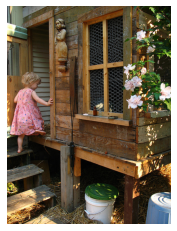

In [26]:
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")
plt.show

So, We can Conclude that Our modle will give 5 caption is seem to be correct which is in Image.

## Data Cleaning
To clean the sentences We usualy perform some NLTK library function like - Stopeword removel, Stemming etc. same as we perform in Sentiment analysis. But here we can not perform these operation here. because we have to manage grammer meaning of the sentences for Eg. if we perform stemming on example "Running" it will make Run which will come out different meaning for the caption.

Here When we deal with text, we generally perform some basic cleaning like lowercasing all the words (otherwise “hello” and “Hello” will be regarded as two separate
words), removing special tokens (like ‘%’, ‘$’, ‘#’, etc.), eliminating words which
contain numbers (like ‘hey199’, etc.).


In [27]:
import re
def Clean_text(Sentence):
    Sentence = Sentence.lower()
    Sentence = re.sub("[^a-z]+"," ",Sentence)
    Sentence = Sentence.split()
    
    Sentence = [s for s in Sentence if (len(s)>1)]
    Sentence = " ".join(Sentence)
    return Sentence

In [28]:
## Check Function for sample Eg.
Clean_text("A cat is sitting over the house #64")

'cat is sitting over the house'

In [29]:
## Clean All the Caption

In [30]:
for key,caption_list in discription.items(): # treated as key, value = key,caption_list
    for i in range(len(caption_list)): # treverse all the 5 caption of single image
        caption_list[i] = Clean_text(caption_list[i])

In [31]:
discription['1000268201_693b08cb0e'] # Check for an image 

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

## Create a vocabulary 
Create a vocabulary of all the unique words present across all the 8000*5 (i.e. 40000) image captions (corpus) in the data set However, if we think about it, many of these words will occur very few times, say 1, 2 or 3 times. Since we are creating a predictive model, we would not like to have all the words present in our vocabulary but the words which are more likely to occur or which are common. This helps the model become more robust to outliers and make less mistakes.

In [32]:
vocabulary  = set()
for key in discription.keys():
    [vocabulary .update(sentence.split()) for sentence in discription[key]]
print("vocabulary  Size : %d" % len(vocabulary ))
    

vocabulary  Size : 8424


In [33]:
## Total number of Words acroos all the Sentences 
total_words = []
for key in discription.keys():
    [total_words.append(i) for des in discription[key] for i in des.split()]
print("Total Words %d"%len(total_words))

Total Words 373837


In [34]:
print(total_words[:10])

['child', 'in', 'pink', 'dress', 'is', 'climbing', 'up', 'set', 'of', 'stairs']


In [35]:
# Hence we consider only those words which occur at least 10 times in the entire corpus. The code for this is below
# Filter Words from the Vocab according to Certaion treshhold frequency

In [36]:
import collections
from collections import Counter
Counter = collections.Counter(total_words)
freq_cnt = dict(Counter)
print (len(freq_cnt.keys())) # this shows that how many time word is occuring 

8424


In [37]:
# Sort this dictonary according to the freq Count

In [38]:
sorted_freq_cnt = sorted(freq_cnt.items(),reverse=True,key=lambda x:x[1])

#Filtering
threshold = 10
sorted_freq_cnt = [x for x in sorted_freq_cnt if x[1]>threshold]
total_word = [x[0] for x in sorted_freq_cnt]

In [39]:
print(len(total_word)) # Show Sorted >freq uniqe words

1845


So We have started with somewhere arount 317000 words and to perfor preproceesing opretion we have left 1845 words

So now we have only 1845 unique words in our vocabulary. However, we will append 0’s (zero padding explained later) and thus total words = 1845+1 = 1846 (one index for the 0).



## Data pre-processing File

In [40]:
with open("discription_1.txt","w") as f:
    f.write(str(discription))
    

## Prepare Train/Test Data

## Read Files

In [41]:
train_file_data = readText("D:\\Desktop\\Flickr_Data\\Flickr_TextData\\Flickr_8k.trainImages.txt")
test_file_data = readText("D:\\Desktop\\Flickr_Data\\Flickr_TextData\\Flickr_8k.testImages.txt")

In [42]:
train = [row.split(".")[0] for row in train_file_data.split("\n")[:-1] ]
test = [row.split(".")[0] for row in test_file_data.split("\n")[:-1] ]

In [43]:
train[:5]

['2513260012_03d33305cf',
 '2903617548_d3e38d7f88',
 '3338291921_fe7ae0c8f8',
 '488416045_1c6d903fe0',
 '2644326817_8f45080b87']

In [44]:
# Now Prepare Description for Training Data 
# Tweak - Add <s> and <e> token to our training data
train_description = {}
for img_id in train:
    train_description[img_id] = []
    for cap in discription[img_id]:
        cap_append = "startseq " + cap + " endseq"
        train_description[img_id].append(cap_append)

In [45]:
train_description['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

## Image  Preprocessing
### Transfer Learning
- Image --> Feature
- Text -->Feture

## Ster - 1 Image Feature Extraction
Images are nothing but input (X) to our model. As you may already know that any input to a model must be given in the form of a vector. We need to convert every image into a fixed sized vector which can then be fed as input to the neural network. For this purpose, we opt for transfer learning by using the ResNet50 model (Convolutional Neural Network).
ResNet50 is not the first model coming from the ResNet family. The original model was called the Residual net or ResNet and was another milestone in the CV domain back in 2015. The main motivation behind this model was to avoid poor accuracy as the model went on to become deeper. Additionally, if you are familiar with Gradient Descent, you would have come across the Vanishing Gradient issue – the ResNet model aimed to tackle this issue as well. ResNet34(ResNet50 also follows a similar technique with just more layers)

In [46]:
model = ResNet50(weights="imagenet", input_shape=(224,224,3)) 
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [47]:
model_new = Model(model.input,model.layers[-2].output)

In [48]:
## Try to extract feature from Image and save in new file
def preprocess_img(img):
    img = image.load_img(img,target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    # Normalisation Data
    img = preprocess_input(img)
    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


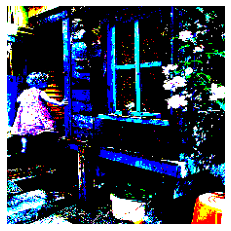

In [49]:
img = preprocess_img("D:\\Desktop\\Flickr_Data\\Images\\1000268201_693b08cb0e.jpg")
plt.imshow(img[0])
plt.axis("off")
plt.show()

## Data Preproccesing for Images/Image Encoding :
It is basically when we feed the image into the madel it gives an enconding as output each corresponding image.
    Preprocessing --> paass through ResNet Model ---> Output(encoding)

In [50]:
def encode_image(img):
    img = preprocess_img(img)
    feature_vector = model_new.predict(img)
    feature_vector = feature_vector.reshape((-1,))
    #print(feature_vector.shape)
    return feature_vector

In [51]:
encode_image("D:\\Desktop\\Flickr_Data\\Images\\1000268201_693b08cb0e.jpg")

array([0.06535921, 0.16782534, 0.3251761 , ..., 0.05107138, 0.32821208,
       1.0043364 ], dtype=float32)

In [52]:
start = time()

encoding_train = {}

for ix, img_id in enumerate(train):
    
    img_path = "D:\\Desktop\\Flickr_Data\\Images\\1000268201_693b08cb0e.jpg"
    encoding_train[img_id] = encode_image(img_path)
    
    if ix%100==0:
        print("Encoding in Progress Time step %d "%ix)
end_t = time()    
print("Time taken in seconds =", time()-start)

Encoding in Progress Time step 0 
Encoding in Progress Time step 100 
Encoding in Progress Time step 200 
Encoding in Progress Time step 300 
Encoding in Progress Time step 400 
Encoding in Progress Time step 500 
Encoding in Progress Time step 600 
Encoding in Progress Time step 700 
Encoding in Progress Time step 800 
Encoding in Progress Time step 900 
Encoding in Progress Time step 1000 
Encoding in Progress Time step 1100 
Encoding in Progress Time step 1200 
Encoding in Progress Time step 1300 
Encoding in Progress Time step 1400 
Encoding in Progress Time step 1500 
Encoding in Progress Time step 1600 
Encoding in Progress Time step 1700 
Encoding in Progress Time step 1800 
Encoding in Progress Time step 1900 
Encoding in Progress Time step 2000 
Encoding in Progress Time step 2100 
Encoding in Progress Time step 2200 
Encoding in Progress Time step 2300 
Encoding in Progress Time step 2400 
Encoding in Progress Time step 2500 
Encoding in Progress Time step 2600 
Encoding in P

### Store everything to the disk

In [53]:
with open("encoding_train_feature.pkl","wb") as f:
    pickle.dump(encoding_train,f)

In [54]:
start = time()
encoding_test = {}
for ix,img_id in enumerate(test):
    img_path = "D:\\Desktop\\Flickr_Data\\Images\\1000268201_693b08cb0e.jpg"
    encoding_test[img_id]=encode_image(img_path)
    
    if ix%100==0:
        print("Test Encoding in progress time step %d "%ix)
end_t = time()
print("Total time taken(Test) :",end_t-start)
    

Test Encoding in progress time step 0 
Test Encoding in progress time step 100 
Test Encoding in progress time step 200 
Test Encoding in progress time step 300 
Test Encoding in progress time step 400 
Test Encoding in progress time step 500 
Test Encoding in progress time step 600 
Test Encoding in progress time step 700 
Test Encoding in progress time step 800 
Test Encoding in progress time step 900 
Total time taken(Test) : 299.0044333934784


In [55]:
with open("encoding_test_feature.pkl","wb") as f:
    pickle.dump(encoding_test,f)

## Data pre-processing for Captions

In [56]:
len(total_word)

1845

In [57]:
word_to_idx = {}
idx_to_word = {}
for i,word in enumerate(total_word):
    word_to_idx[word] = i+1
    idx_to_word[i+1] = word
    

In [58]:
word_to_idx["dog"]


6

In [59]:
idx_to_word[6]

'dog'

In [60]:
print(len(idx_to_word))

1845


In [61]:
# Two special words
idx_to_word[1846] = 'startseq'
word_to_idx['startseq'] = 1846

idx_to_word[1847] = 'endseq'
word_to_idx['endseq'] = 1847

vocab_size = len(word_to_idx)+1
print("vocab size", vocab_size)

vocab size 1848


In [62]:
max_len = 0
for key in train_description.keys():
    for cap in train_description[key]:
        max_len = max(max_len,len(cap.split()))
        
print(max_len)

35


## Data Loader (Generator)

In [110]:

def data_generator(train_description, encoding_train, word_to_idx, max_len, num_photos_per_batch):

    X1, X2, y = [], [], []

    n=0

    while True:
        
        for key, desc_list in train_description.items():
            n +=1

            photo = encoding_train[key+".jpg"]

            for desc in desc_list:
                
                seq = [ word_to_idx[word] for word in desc.split() if word in word_to_idx]  

                for i in range(1,len(seq)):

                    in_seq = seq[0:i]
                    out_seq = seq[i]

                    in_seq = pad_sequences([in_seq], maxlen=max_len, value=0, padding='post')[0]

                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n==num_photos_per_batch:
                yield [[np.array(X1), np.array(X2)], np.array(y)]
                X1, X2, y = [], [], []
                n=0

## Word Embedding

In [102]:
f = open("D:\\Desktop\\datasets\\glove.6B.50d.txt", encoding = 'utf8')

In [104]:
embedding_index = {}
for line in f:
    values = line.split()
    word = values[0]
    word_embedding = np.array(values[1:],dtype ='float')
    embedding_index[word] = coefs
    

In [105]:
f.close()

In [86]:
embedding_index['apple']

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ])

## Converting words into vectors Directly - (Embedding Layer Output)


In [106]:

def get_embedding_output():
    
    emb_dim = 50
    embedding_output = np.zeros((vocab_size,emb_dim))
    
    for word, idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            embedding_output[idx] = embedding_vector
            
    return embedding_output


embedding_output = get_embedding_output()

In [107]:
embedding_matrix = get_embedding_matrix()
embedding_matrix.shape

(1848, 50)

In [89]:
#embedding_matrix[1847]

## Model Architecture

In [90]:
input_img_features = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_features)
inp_img2 = Dense(256,activation='relu')(inp_img1)

In [91]:
# Captions as Input
input_captions = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [92]:
decoder1 = add([inp_img2,inp_cap3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2)

#Combined Model

model = Model(inputs=[input_img_features,input_captions],outputs=outputs)


In [93]:
model.summary() # Basicallly Show How my Lyers are connected

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 35)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 35, 50)       92400       input_5[0][0]                    
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 2048)         0           input_4[0][0]                    
____________________________________________________________________________________________

In [94]:
# Important thing - Embedding Layer
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainble = False

In [95]:
model.compile(loss='categorical_crossentropy', optimizer="adam")

### Training of Model

In [108]:
epochs = 10
number_pics_per_batch = 3
steps = len(train_description)//number_pics_per_batch

In [111]:
for i in range(epochs):
    generator = data_generator(train_description, encoding_train, word_to_idx, max_len, number_pics_per_batch)
    Model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('./model_weights/model_' + str(i) + '.h5')

TypeError: fit_generator() missing 1 required positional argument: 'generator'

## Predictions

In [258]:
def predict_caption(photo):
    in_text = "startseq"
    
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence], maxlen=max_len, padding='post')

        ypred =  model.predict([photo,sequence])
        ypred = ypred.argmax()
        word = idx_to_word[ypred]
        in_text+= ' ' +word
        
        if word =='endseq':
            break
        
        
    final_caption =  in_text.split()
    final_caption = final_caption[1:-1]
    final_caption = ' '.join(final_caption)
    
    return final_caption

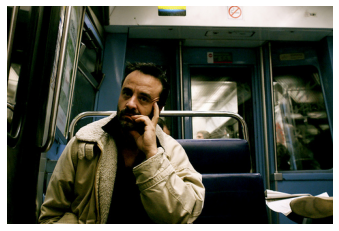

touching touching touching wave touching touching wave touching wave touching touching wave touching touching wave touching touching wave touching touching wave touching touching wave touching touching wave touching touching wave touching touching wave touching


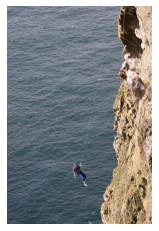

touching touching touching wave touching touching wave touching wave touching touching wave touching touching wave touching touching wave touching touching wave touching touching wave touching touching wave touching touching wave touching touching wave touching


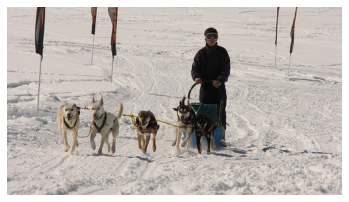

touching touching touching wave touching touching wave touching wave touching touching wave touching touching wave touching touching wave touching touching wave touching touching wave touching touching wave touching touching wave touching touching wave touching


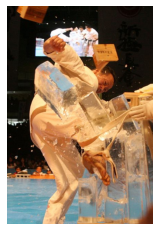

touching touching touching wave touching touching wave touching wave touching touching wave touching touching wave touching touching wave touching touching wave touching touching wave touching touching wave touching touching wave touching touching wave touching


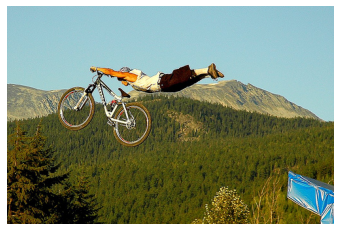

touching touching touching wave touching touching wave touching wave touching touching wave touching touching wave touching touching wave touching touching wave touching touching wave touching touching wave touching touching wave touching touching wave touching


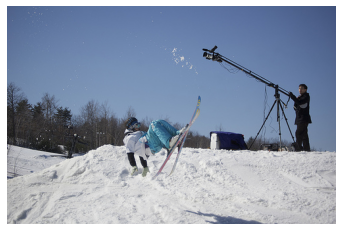

touching touching touching wave touching touching wave touching wave touching touching wave touching touching wave touching touching wave touching touching wave touching touching wave touching touching wave touching touching wave touching touching wave touching


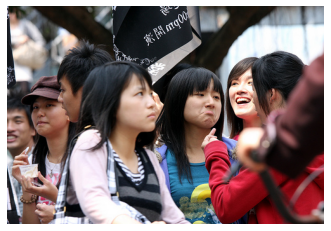

touching touching touching wave touching touching wave touching wave touching touching wave touching touching wave touching touching wave touching touching wave touching touching wave touching touching wave touching touching wave touching touching wave touching


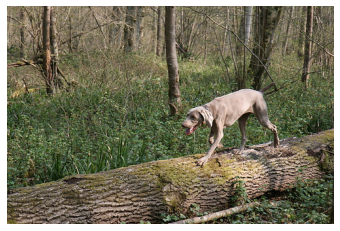

touching touching touching wave touching touching wave touching wave touching touching wave touching touching wave touching touching wave touching touching wave touching touching wave touching touching wave touching touching wave touching touching wave touching


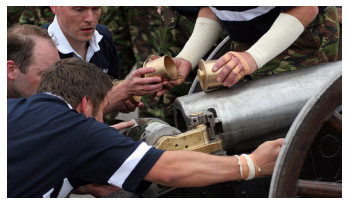

touching touching touching wave touching touching wave touching wave touching touching wave touching touching wave touching touching wave touching touching wave touching touching wave touching touching wave touching touching wave touching touching wave touching


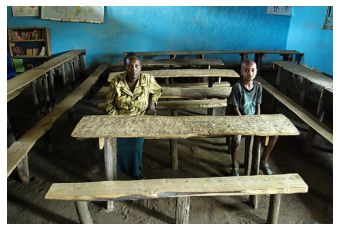

touching touching touching wave touching touching wave touching wave touching touching wave touching touching wave touching touching wave touching touching wave touching touching wave touching touching wave touching touching wave touching touching wave touching


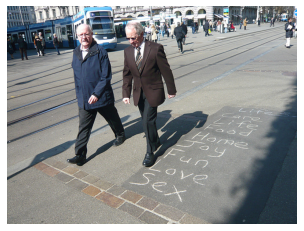

touching touching touching wave touching touching wave touching wave touching touching wave touching touching wave touching touching wave touching touching wave touching touching wave touching touching wave touching touching wave touching touching wave touching


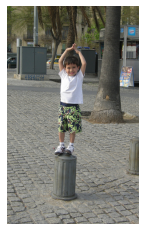

touching touching touching wave touching touching wave touching wave touching touching wave touching touching wave touching touching wave touching touching wave touching touching wave touching touching wave touching touching wave touching touching wave touching


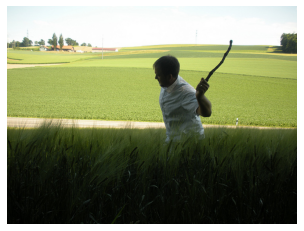

touching touching touching wave touching touching wave touching wave touching touching wave touching touching wave touching touching wave touching touching wave touching touching wave touching touching wave touching touching wave touching touching wave touching


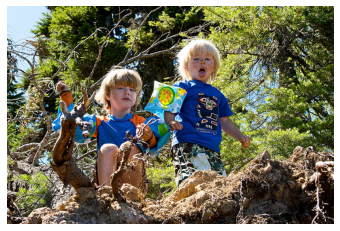

touching touching touching wave touching touching wave touching wave touching touching wave touching touching wave touching touching wave touching touching wave touching touching wave touching touching wave touching touching wave touching touching wave touching


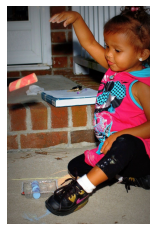

touching touching touching wave touching touching wave touching wave touching touching wave touching touching wave touching touching wave touching touching wave touching touching wave touching touching wave touching touching wave touching touching wave touching


In [274]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

for i in range(15):
    rn =  np.random.randint(0, 1000)

    img_name = list(encoding_test.keys())[rn]
    photo = encoding_test[img_name].reshape((1,2048))

    i = plt.imread("D:\\Desktop\\Flickr_Data\\Images\\"+img_name+".jpg")
    plt.imshow(i)
    plt.axis("off")
    plt.show()

    caption = predict_caption(photo)
    print(caption)